In [1]:
import random
from IPython.core.display import SVG
import pyomo.environ as pyo
from pysat.solvers import Solver
from pysat.formula import CNF 
import py_svg_combinatorics as psc
from ipywidgets import widgets, HBox
from collections import Counter
from pprint import pprint
from random import randint
import numpy as np
from IPython.display import IFrame
import networkx as nx
import IPython
from copy import copy
import os
from pathlib import Path
def print_solution(m):
    for v in m.component_data_objects(pyo.Var):
        if v.value and v.value > 0:
            print(str(v), v.value)

nbname = ''
try:
    nbname = __vsc_ipynb_file__
except:
    if 'COCALC_JUPYTER_FILENAME' in os.environ:
        nbname = os.environ['COCALC_JUPYTER_FILENAME']
title_ = Path(nbname).stem.replace('-', '_').title()
IFrame('https://discopal.ispras.ru/index.php?title=Hardprob/Minimum_Graph_Coloring&useskin=cleanmonobook',  width="100%", height=300)

In [2]:
def visme(G, m=None):
    def norm_size(sz):
        return int(sz*100)

    pos = nx.get_node_attributes(G, "pos")
    if not pos:
        pos = nx.shell_layout(G)
    cut_edges = None
    v_colors = ['limegreen']*len(G.nodes())

    if m:
        v_colors = colors

    nx.draw_networkx(
        G,
        pos,
        with_labels=True,
        edge_color="blue",
        node_color=v_colors,
        node_size=300,
        style=':',
        width=0.8,
        font_size=9
    )

    if cut_edges:
        nx.draw_networkx_edges(
            G,
            pos,
            edgelist=cut_edges,
            edge_color="blue",
            node_size=200,
            width=0.7,
        )

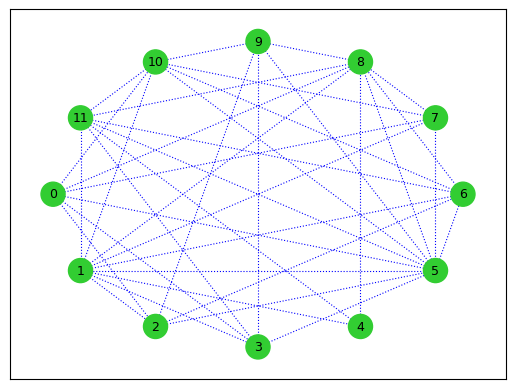

In [3]:
n = 12
G = nx.fast_gnp_random_graph(n, 0.5, directed=False)
#print(colors)
for (u, v) in G.edges():
    G.edges[u, v]['weight'] = 1 #np.random.rand()

visme(G)

In [4]:
ncolors = n
color_nums = range(ncolors)
colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(n)]

In [5]:
def get_model(G):
    m = pyo.ConcreteModel()

    m.E = m.A = list(G.edges())
    m.V = list(G.nodes())
    m.W = dict([(e[:2], e[2]['weight']) for e in G.edges(data=True)])
    m.m = len(m.A)
    m.n = len(m.V)
    m.c = list(color_nums)

    # 0-1 — покрашена ли вершина с номером i в цвет h.
    m.x = pyo.Var(list(G.nodes()), color_nums, within=pyo.Binary)

    # 0-1 — использован ли цвет h.
    m.y = pyo.Var(color_nums, domain=pyo.Binary)

    m.min_color = pyo.Objective(expr = sum(m.y[h] for h in m.y), sense=pyo.minimize)

    @m.Constraint(m.V)
    def каждая_вершина_покрашена_ровно_в_один_цвет(m, u):
        return sum(m.x[u, h] for h in m.y) == 1

    @m.Constraint(m.A, m.c)
    def вершины_каждого_ребра_покрашены_в_разные_цвета(m, u, v, h):
        return m.x[u, h] + m.x[v, h] <= m.y[h]

    return m


m = get_model(G)

In [6]:
solver = pyo.SolverFactory('cbc')
solver.solve(m).write()
print_solution(m)

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 5.0
  Upper bound: 5.0
  Number of objectives: 1
  Number of constraints: 468
  Number of variables: 156
  Number of binary variables: 156
  Number of integer variables: 156
  Number of nonzeros: 12
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 0.07
  Wallclock time: 0.09
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch and bound

In [7]:
y = list(filter(lambda x: (m.y[x].value > 0) , m.y))
colors_num = []
for v in m.V:
    for c in y:
        if m.x[v, c].value > 0:
            colors_num.append(c)
            break;
our_color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(n)]
colors = list(our_color[x] for x in colors_num)

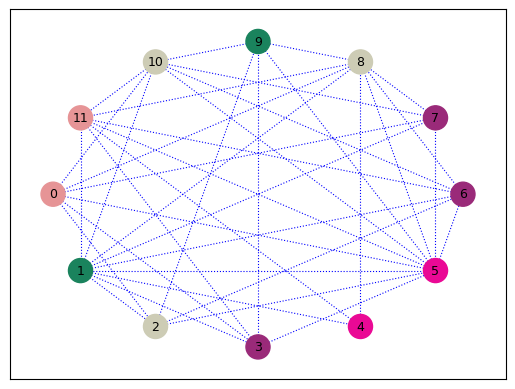

In [8]:
visme(G, m)